In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext

In [2]:
import gensim

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True) 

/databricks/python/local/lib/python2.7/site-packages/smart_open/smart_open_lib.py:566: UserWarning: streaming gzip support unavailable, see https://github.com/RaRe-Technologies/smart_open/issues/189
 warnings.warn('streaming gzip support unavailable, see %s' % _ISSUE_189_URL)

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!

In [4]:
def removeStopWords(unique_word_lst):
  stop_words = set(stopwords.words('english')) 
  filtered_sentence = [] 
  for w in unique_word_lst: 
      w_lower = w.lower()
      if w_lower not in stop_words: 
          filtered_sentence.append(w) 
  return filtered_sentence
# print(removeStopWords(['W']))

In [5]:
def createDictVector(word_list,unique_word_lst):
  vector = [0] * len(unique_word_lst)
  for word in word_list:
    indx = unique_word_lst.index(word)
    vector[indx] = 1
  return vector

In [6]:
import re
def split_and_merge_vector2(words,model,unique_word_lst):
  words = words.strip()
  word_list = re.split(' |,|/',words)
  word_list  = list(filter(None, word_list))
  filtered_word_list = removeStopWords(word_list)
  print(filtered_word_list)
#   print(word_list)
  vector_lst = []
  count = 0
  for word in word_list:
    try:
      vector = model[word].tolist()
      vector = vector + createDictVector(filtered_word_list,unique_word_lst)
    except KeyError:
      continue
    vector_lst.append(vector)
    count = count+1
  if count == 0:
    return []
  return [sum(x)/count for x in zip(*vector_lst)]
# split_and_merge_vector2(" cat catB cat ",model,["cat","catB","dog"])[301]

In [7]:
import unicodedata
def unicodeToString(uw):
  return unicodedata.normalize('NFKD', uw).encode('ascii','ignore')
def category_des_lst(category):
  cate_df = crimeDF_new.filter(crimeDF_new.Category == category).sort('Descript')
  des_df = cate_df.select('Descript').distinct()
  # print(assault_df.count())
  # display(assault_df)
  return [unicodeToString(i.Descript) for i in des_df.collect()]

In [8]:
def featureVectorForCategory2(des_lst,unique_word_lst):
  feature_vectors = []
  for words in des_lst:
    feature_vectors.append(split_and_merge_vector2(words,model,unique_word_lst))
  return feature_vectors

In [9]:
from sklearn.cluster import KMeans
import numpy as np
def Kmean_cluster(num_clusters,word_vectors):
  X = np.array(word_vectors)
  kmeans_fit = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
  cluster_labels = kmeans_fit.labels_
  return cluster_labels
def mergeLabelWithDescription(labels,des_lst):
  tup_lst = zip(labels,des_lst)
  rdd = sc.parallelize(tup_lst)
  rdd = rdd.map(lambda tup: (int(tup[0]), tup[1]))
  return rdd.sortBy(lambda tup: tup[0])

In [10]:
import re
def flatternAndCreateDict(des_lst):
  s = set()
  for words in des_lst:
    ws = re.split(' |,|/',words)
    for word in ws:
      s.add(word)
  return list(s)

In [11]:
def createJoinDF(category):
  des_count_df = crimeDF_new.filter(crimeDF_new.Category == category).select('Category','Descript').groupBy('Descript').count()
  cate_des_df = crimeDF_new.filter(crimeDF_new.Category == category).select('Category','Descript').sort('Descript').distinct()
  joinDF = cate_des_df.join(des_count_df,"Descript").cache()
#   display(joinDF)
  return  joinDF

In [12]:
def sub_count_lst(cate_joinDF,cate_df):
  sub_df = cate_joinDF.join(cate_df,"Descript").cache()
  # display(assault_sub_df)
  sub_df = sub_df.groupby("subCategory").agg({'count':'sum'})
  sub_count_lst = [i["sum(count)"] for i in sub_df.collect()]
  # display(assault_sub_df.groupby("subCategory").agg({'count':'sum'}))
  return sub_count_lst

In [13]:
def dfColToList(df,colName):
  if colName != "count":
    return [unicodeToString(i[colName]) for i in df.collect()]
  else:
    return [i[colName] for i in df.collect()]

In [14]:
#combine everything tgt for generate a subcategory count lst
def genSubCateCountLst(category):
  joinDF = createJoinDF(category).cache()
  des_lst = category_des_lst(category)
  unique_word_lst = flatternAndCreateDict(des_lst)
  unique_word_lst = removeStopWords(unique_word_lst)
  feature_vecs = featureVectorForCategory2(des_lst,unique_word_lst)
  df = subDescriptDF_Kmeans(feature_vecs,des_lst).cache()
  return sub_count_lst(joinDF,df)

In [15]:
#START TO ANALYZE THE DATA
crimeDF = spark.read.format('csv').options(header='true', inferSchema='true').load('/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

In [16]:
crimeDF_new = crimeDF.sort("Category").select('Category','Descript').cache()

In [17]:
Category_count = crimeDF_new.groupBy("Category").count()
Category_count = Category_count.sort('count', ascending=False).cache()
Important_Categories = Category_count.filter("`count` >= 120000").cache()

In [18]:
Important_Categories.show()
display(Important_Categories)

Category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602


In [19]:
lst = genSubCateCountLst('LARCENY/THEFT')+\
  genSubCateCountLst('OTHER OFFENSES')+\
  genSubCateCountLst('NON-CRIMINAL')+\
  genSubCateCountLst('ASSAULT') +\
  genSubCateCountLst('VEHICLE THEFT')

subCategory,Descript
0,TAMPERING WITH A VEHICLE
0,"VEHICLE, RENTAL, FAILURE TO RETURN"
1,STOLEN AUTOMOBILE
1,STOLEN BUS
1,STOLEN MOTORCYCLE
1,STOLEN TRAILER
1,STOLEN TRUCK
2,"VEHICLE, RECOVERED, AUTO"
2,"VEHICLE, RECOVERED, BUS"
2,"VEHICLE, RECOVERED, CAMPER-HOUSE CAR-MOTOR HOME"


In [20]:
#subcategories count list for all category in order
print(lst)

[173208, 7624, 140, 294679, 4797, 65, 141701, 83196, 70766, 13630, 28929, 948, 115841, 85703, 6902, 67978, 4269, 1918, 41451, 78846, 93001, 10604, 176, 22308, 513]

In [21]:
category_lst = dfColToList(Important_Categories,"Category")
cate_count_lst = dfColToList(Important_Categories,"count")
print(category_lst)
print(cate_count_lst)

['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', 'VEHICLE THEFT']
[480448, 309358, 238323, 194694, 126602]

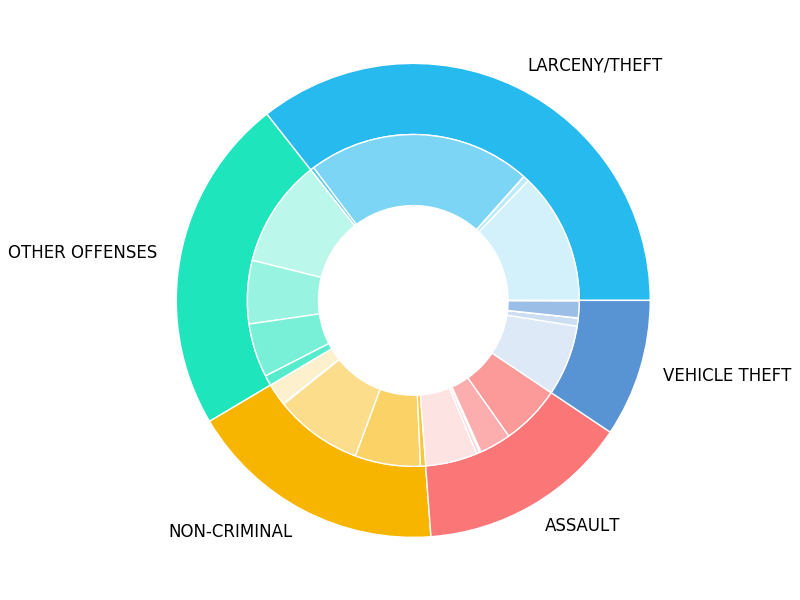

In [22]:
#TODO delete this if unnecessary
#plot outer donut
def hexToRGB(h):
  h = h.lstrip('#')
  return tuple(int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4))

import matplotlib.pyplot as plt
cout = ['#26baee','#1fe5bd','#f8b500','#fb7777','#5893d4']
cin = [ hexToRGB(c)+(i,) for c in cout for i in [0.2,0.3,0.45,0.6,0.75]]
fig, ax = plt.subplots()
size = 0.3
ax.pie(cate_count_lst, labels=category_lst,wedgeprops=dict(width=size, edgecolor='w'),colors=cout)
ax.pie(lst, radius=1-size,wedgeprops=dict(width=size, edgecolor='w'),colors=cin)
ax.axis('equal')
plt.show()
display(fig)

In [23]:
assault_joinDF = createJoinDF('ASSAULT')
non_crime_joinDF = createJoinDF('NON-CRIMINAL')
# union_DF = assault_joinDF.union(non_crime_joinDF)
# display(union_DF.filter("`count` >= 10000"))

Descript,Category,count
AGGRAVATED ASSAULT WITH A DEADLY WEAPON,ASSAULT,16405
THREATS AGAINST LIFE,ASSAULT,34670
BATTERY,ASSAULT,67654
INFLICT INJURY ON COHABITEE,ASSAULT,17948
AGGRAVATED ASSAULT WITH BODILY FORCE,ASSAULT,12522
LOST PROPERTY,NON-CRIMINAL,77956
"AIDED CASE, MENTAL DISTURBED",NON-CRIMINAL,56313
FOUND PROPERTY,NON-CRIMINAL,33383
"DEATH REPORT, CAUSE UNKNOWN",NON-CRIMINAL,10735
AIDED CASE,NON-CRIMINAL,14250


In [24]:
#RUN CMD 11-12 FIRST
#example using category ASSAULT to ge list of descriptions
des_assault_lst = category_des_lst('ASSAULT')

In [25]:
#example for unique description from assault category
  unique_word_lst = flatternAndCreateDict(des_assault_lst)
len(unique_word_lst)
print(unique_word_lst)

['', 'MARKING', 'THREATS', 'SIMPLE', 'WITHIN', 'LIFE', 'LABOR', 'AGGRAVATED', 'DURING', 'WITH', 'BY', 'HOMICIDE', 'FORCE', 'WEAPON', 'OFFICIAL', 'OFFICERS', 'CHEMICALS', '(HATE', 'EMPLOYEE', 'DATING', 'CONDITION', 'FULL', 'DWELLING', 'ON', 'PEACE', 'TRESPASS', 'EMBEZZLEMENT', 'SCHOOL', 'OF', 'COHABITEE', 'UNLAWFUL', 'DAMAGE', 'ASSAULT', 'ABUSE', 'JUDGE', 'INJURY', 'OR', 'RESISTING', 'UPON', 'GUN', 'RESIST', 'POISONING', "GOV'T", 'INJURIES', '(PHYSICAL)', 'DISCHARGING', 'EXPLOSIVE', 'TRAUMATIC', 'DEPENDENT', 'DEADLY', 'PHONE', 'THEFT)', 'W', '(NOT', 'WILLFUL', 'DISPUTE', 'PROPERTY', 'TERRORIZING', 'THEIR', 'ATTEMPTED', '30', 'DAYS', 'PUBLIC', 'LIGHTS', 'CREDIBLE', 'INCL.', 'CRIMES)', 'VEHICLE', 'CRUELTY', 'DEATH', 'THREAT', 'SPOUSE', 'FORMER', 'EXPLOSIVES', 'EXECUTIVE', 'TEACHERS', 'INHABITED', 'MURDER', 'DANGEROUS', 'THREATENING', 'BLDG', 'BODILY', 'STATE', 'OFFICER', 'KNIFE', 'FALSE', 'RIGHTS', 'STALKING', 'NEGLIGENT', 'INFLICT', 'FIREARM', 'RELATIONSHIP', 'INFLICTING', 'AIRCRAFT', 'DISSUADING', 'RESULTING', 'LASERS', 'POLICE', 'SEMI', 'ELDER', 'OCCUPIED', 'PRIVATE', 'TO', 'GROSSLY', 'CAUSTIC', 'WITNESS', 'A', 'ARSON', 'AUTO', 'INTO', 'IMPRISONMENT', 'AGAINST', 'MACHINE', 'MAYHEM', 'CAUSING', 'AT', 'IN', 'DEVICE', 'SERIOUS', 'SHOOTING', 'CALL(S)', 'BATTERY', 'CIVIL', 'SNIPING', 'ADULT', 'CHILD', 'MANNER']

In [26]:
#remove stop words from unique des list
unique_word_lst = removeStopWords(unique_word_lst)
print(len(unique_word_lst))

114

In [27]:
#example feature map of ASSAULT category
feature_vecs_assualt2 = featureVectorForCategory2(des_assault_lst,unique_word_lst)
print(len(feature_vecs_assualt2[0]))

['AGGRAVATED', 'ASSAULT', 'POLICE', 'OFFICER', 'SNIPING']
['AGGRAVATED', 'ASSAULT', 'POLICE', 'OFFICER', 'BODILY', 'FORCE']
['AGGRAVATED', 'ASSAULT', 'POLICE', 'OFFICER', 'GUN']
['AGGRAVATED', 'ASSAULT', 'POLICE', 'OFFICER', 'KNIFE']
['AGGRAVATED', 'ASSAULT', 'DEADLY', 'WEAPON']
['AGGRAVATED', 'ASSAULT', 'GUN']
['AGGRAVATED', 'ASSAULT', 'KNIFE']
['AGGRAVATED', 'ASSAULT', 'BODILY', 'FORCE']
['ASSAULT']
['ASSAULT', 'POISONING']
['ASSAULT', 'POLICE', 'OFFICER']
['ASSAULT', 'POLICE', 'OFFICER', 'DEADLY', 'WEAPON']
['ASSAULT', 'ATTEMPTED', 'MURDER', 'UPON', "GOV'T", 'OFFICERS']
['ASSAULT', 'CAUSTIC', 'CHEMICALS']
['ASSAULT', 'AGGRAVATED', 'POLICE', 'OFFICER', 'W', 'FULL', 'AUTO']
['ASSAULT', 'AGGRAVATED', 'POLICE', 'OFFICER', 'W', 'GUN']
['ASSAULT', 'AGGRAVATED', 'POLICE', 'OFFICER', 'W', 'SEMI', 'AUTO']
['ASSAULT', 'AGGRAVATED', 'W', 'GUN']
['ASSAULT', 'AGGRAVATED', 'W', 'MACHINE', 'GUN']
['ASSAULT', 'AGGRAVATED', 'W', 'SEMI', 'AUTO']
['ATTEMPTED', 'HOMICIDE', 'SNIPING']
['ATTEMPTED', 'HOMICIDE', 'DANGEROUS', 'WEAPON']
['ATTEMPTED', 'HOMICIDE', 'GUN']
['ATTEMPTED', 'HOMICIDE', 'KNIFE']
['ATTEMPTED', 'HOMICIDE', 'BODILY', 'FORCE']
['ATTEMPTED', 'HOMICIDE', 'EXPLOSIVES']
['ATTEMPTED', 'MAYHEM', 'DEADLY', 'WEAPON']
['ATTEMPTED', 'MAYHEM', 'GUN']
['ATTEMPTED', 'MAYHEM', 'KNIFE']
['ATTEMPTED', 'MAYHEM', 'BODILY', 'FORCE']
['ATTEMPTED', 'SIMPLE', 'ASSAULT']
['BATTERY']
['BATTERY', 'LABOR', 'DISPUTE']
['BATTERY', 'POLICE', 'OFFICER']
['BATTERY', 'SERIOUS', 'INJURIES']
['BATTERY', 'FORMER', 'SPOUSE', 'DATING', 'RELATIONSHIP']
['CHILD', 'ABUSE', '(PHYSICAL)']
['CHILD', 'INFLICTING', 'INJURY', 'RESULTING', 'TRAUMATIC', 'CONDITION']
['CIVIL', 'RIGHTS', 'INCL.', 'INJURY', 'THREAT', 'DAMAGE', '(HATE', 'CRIMES)']
['DISCHARGING', 'GROSSLY', 'NEGLIGENT', 'MANNER']
['ELDER', 'ADULT', 'DEPENDENT', 'ABUSE', '(NOT', 'EMBEZZLEMENT', 'THEFT)']
['FALSE', 'IMPRISONMENT']
['FIREARM', 'DISCHARGING', 'OCCUPIED', 'BLDG', 'VEHICLE', 'AIRCRAFT']
['FIREARM', 'DISCHARGING', 'GROSSLY', 'NEGLIGENT', 'MANNER']
['INFLICT', 'INJURY', 'COHABITEE']
['LASERS', 'DISCHARGING', 'LIGHTS', 'AIRCRAFT']
['MAYHEM', 'DEADLY', 'WEAPON']
['MAYHEM', 'GUN']
['MAYHEM', 'KNIFE']
['MAYHEM', 'BODILY', 'FORCE']
['RESISTING', 'PEACE', 'OFFICER', 'CAUSING', 'SERIOUS', 'INJURY', 'DEATH']
['SHOOTING', 'INHABITED', 'DWELLING', 'OCCUPIED', 'VEHICLE']
['STALKING']
['TERRORIZING', 'ARSON', 'EXPLOSIVE', 'DEVICE']
['TERRORIZING', 'MARKING', 'PRIVATE', 'PROPERTY']
['THREAT', 'FORCE', 'RESIST', 'EXECUTIVE', 'OFFICER']
['THREAT', 'STATE', 'OFFICIAL', 'JUDGE']
['THREATENING', 'PHONE', 'CALL(S)']
['THREATENING', 'SCHOOL', 'PUBLIC', 'EMPLOYEE']
['THREATS', 'LIFE']
['THREATS', 'SCHOOL', 'TEACHERS']
['TRESPASS', 'WITHIN', '30', 'DAYS', 'CREDIBLE', 'THREAT']
['UNLAWFUL', 'DISSUADING', 'THREATENING', 'WITNESS']
['WILLFUL', 'CRUELTY', 'CHILD']
414

In [28]:
#example: display the subcategory with assault
def subDescriptDF_Kmeans(feature_vecs,des_lst):
  labels = Kmean_cluster(5,feature_vecs)
  rdd = mergeLabelWithDescription(labels,des_lst).collect()
  schema = StructType([StructField("subCategory", IntegerType(), True),\
                       StructField("Descript", StringType(), True),])
  df = spark.createDataFrame(rdd, schema)
  # assault_rdd.groupByKey().mapValues(list).collect()
  display(df)
  return df
assault_df = subDescriptDF_Kmeans(feature_vecs_assualt2,des_assault_lst)

subCategory,Descript
0,BATTERY
0,BATTERY DURING LABOR DISPUTE
0,BATTERY WITH SERIOUS INJURIES
0,"BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP"
1,CHILD ABUSE (PHYSICAL)
1,"CHILD, INFLICTING INJURY RESULTING IN TRAUMATIC CONDITION"
1,"CIVIL RIGHTS, INCL. INJURY, THREAT, OR DAMAGE (HATE CRIMES)"
1,DISCHARGING IN GROSSLY NEGLIGENT MANNER
1,ELDER ADULT OR DEPENDENT ABUSE (NOT EMBEZZLEMENT OR THEFT)
1,FALSE IMPRISONMENT


In [29]:
print(sub_count_lst(assault_joinDF,assault_df))

[67978, 4269, 1918, 41451, 78846]